# Models Comparison
Comparaison des scores des différentes expériences réalisées dans ce projet

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import geopandas as gpd

from keras.layers import LeakyReLU
from shapely import wkt

from IAdeforestation.tools import *
from IAdeforestation.training import *
from IAdeforestation.evaluation import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Path definition

In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models')
TENSORFLOW_HUB_PATH = os.path.join('tensowflow_hub')
TRANSFER_LEARNING_PATH = os.path.join('transfer_learning')
FROM_SCRATCH_PATH = os.path.join('from_scratch')
FINE_TUNING_PATH = os.path.join('all_layers_unfreeze')
MULTI_LABEL_PATH = os.path.join('multi_label')

# Coffee - Startified dataset

In [5]:
paths = {
    'ResNet 64x64':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Coffee','strat_coffee_2', 'strat_coffee_2.json'),
    'ResNet 32x32':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Coffee','strat_coffee_32_1', 'strat_coffee_32_1.json'),
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_2', 'start_coffee_2.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','strat_coffee_32_1', 'strat_coffee_32_1.json'),
    'DenseNet 64x64 \nVietnam params':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_vietnam_2', 'start_coffee_vietnam_2.json'),
    'DenseNet 32x32 \nVietnam params':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_vietnam_32_1', 'start_coffee_vietnam_32_1.json'),
    'DenseNet 64x64 \n300 epochs\nFocal loss':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_300E_focal_2', 'start_coffee_300E_focal_2.json'),
}

## Boxplots

In [6]:
epochs_accs = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        epochs_accs.append(list(zip(*data))[1])
        epochs_loss.append(list(zip(*data))[0])


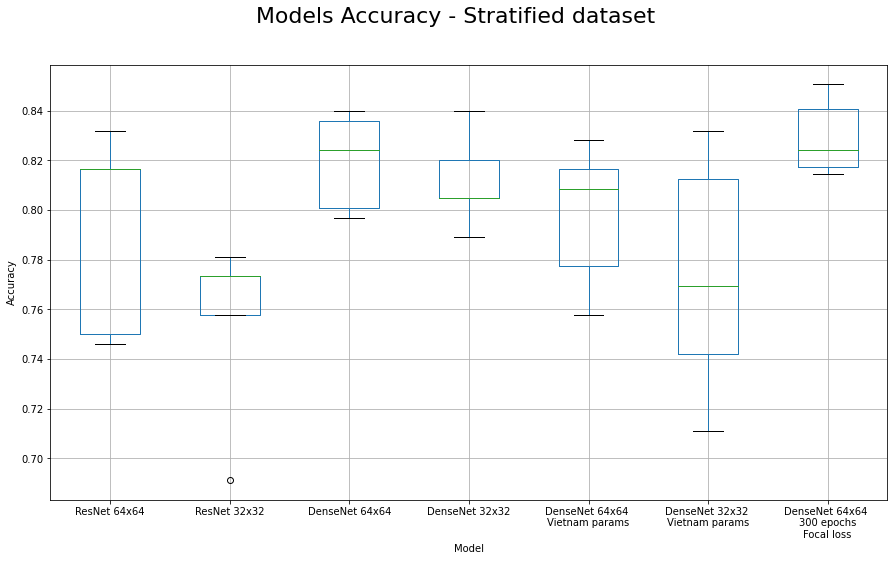

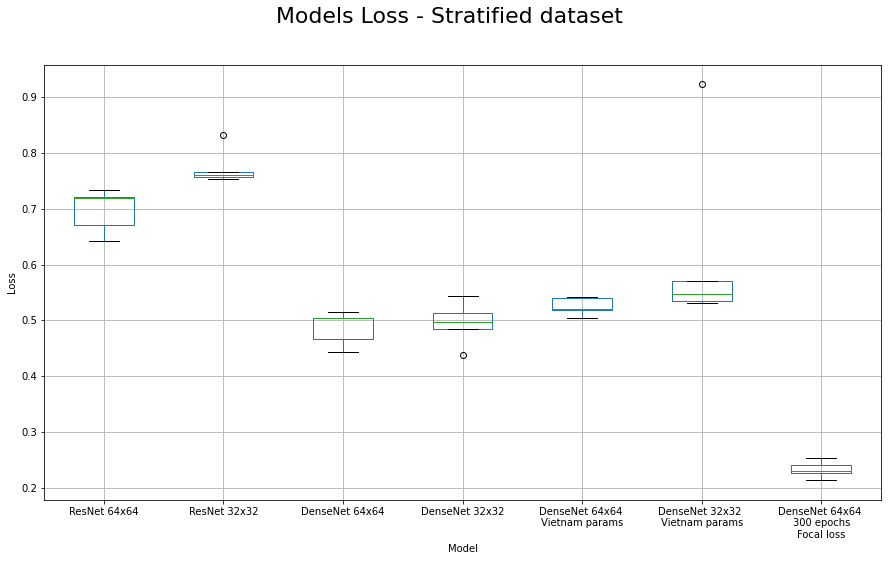

In [7]:
dict_metrics = {'Accuracy':epochs_accs, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Stratified dataset", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

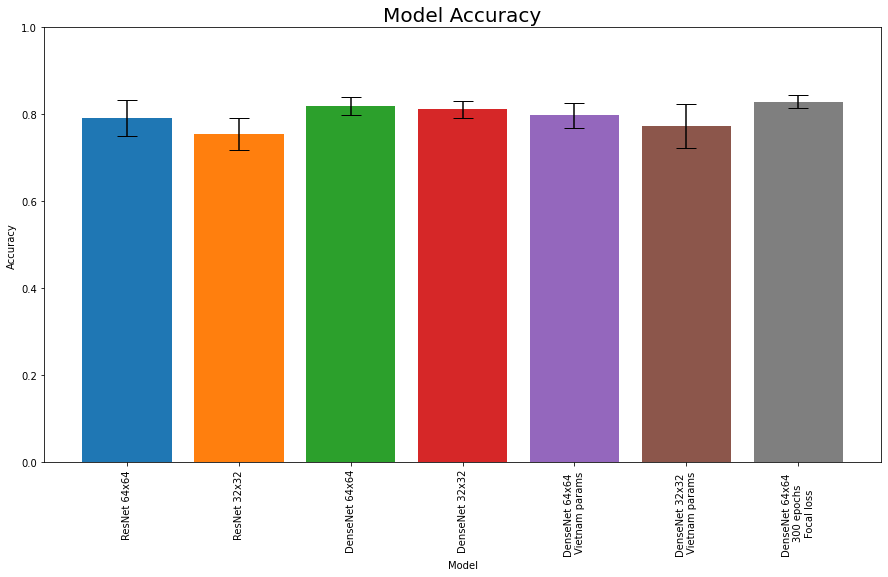

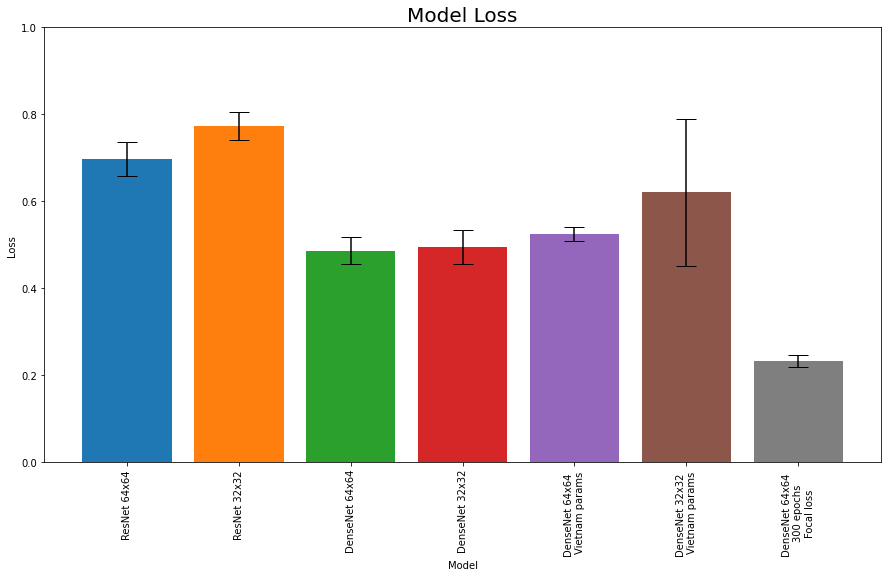

In [8]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [15]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 2s 2s/step - loss: 0.4425 - accuracy: 0.8402 - precision: 0.9524 - recall: 0.8307
Mean accuracy : 0.832
Stdev accuracy : 0.0086


Mean loss : 0.4611
Stdev loss : 0.0125


F1-Score Coffee: 0.747
F1-Score Other: 0.8908
Macro F1-Score : 0.8189


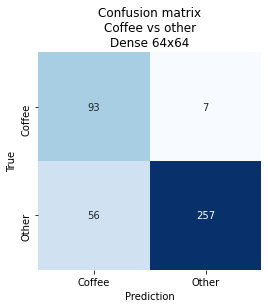

In [17]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCoffee vs other\nDense 64x64")

### DenseNet 64x64 300 epochs Focal loss

1/1 [==============================] - 3s 3s/step - loss: 0.2278 - accuracy: 0.8184 - precision: 0.9312 - recall: 0.8211
Mean accuracy : 0.8165
Stdev accuracy : 0.0092


Mean loss : 0.2312
Stdev loss : 0.0121


F1-Score Coffee: 0.692
F1-Score Other: 0.8761
Macro F1-Score : 0.784


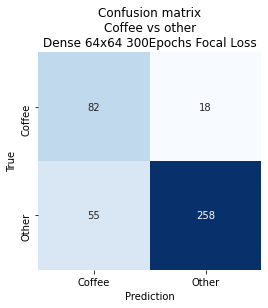

In [20]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','start_coffee_300E_focal_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCoffee vs other\nDense 64x64 300Epochs Focal Loss")

# Culture - Stratified dataset

In [21]:
paths = {
    'ResNet 64x64':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Culture','strat_culture_1', 'strat_culture_1.json'),
    'ResNet 32x32':os.path.join(SAVED_MODELS_PATH, TENSORFLOW_HUB_PATH, 'Culture','strat_culture_32_1', 'strat_culture_32_1.json'),
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_1', 'strat_culture_1.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_32_c1', 'strat_culture_32_c1.json')
}

In [22]:
epochs_accs = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        epochs_accs.append(list(zip(*data))[1])
        epochs_loss.append(list(zip(*data))[0])


## Boxplot

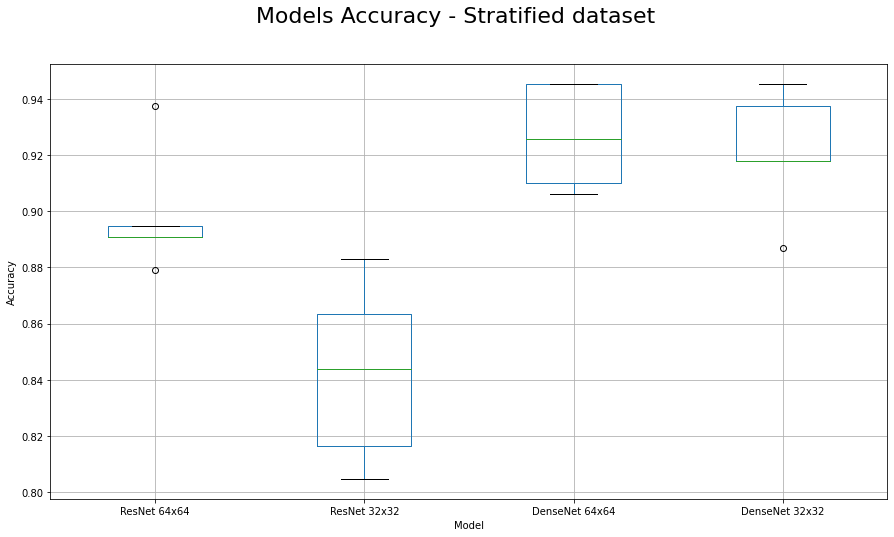

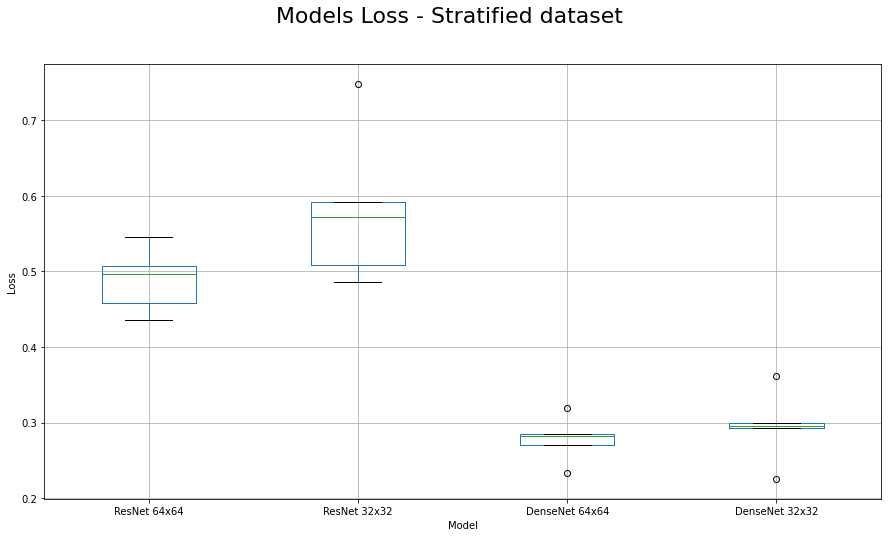

In [23]:
dict_metrics = {'Accuracy':epochs_accs, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Stratified dataset", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

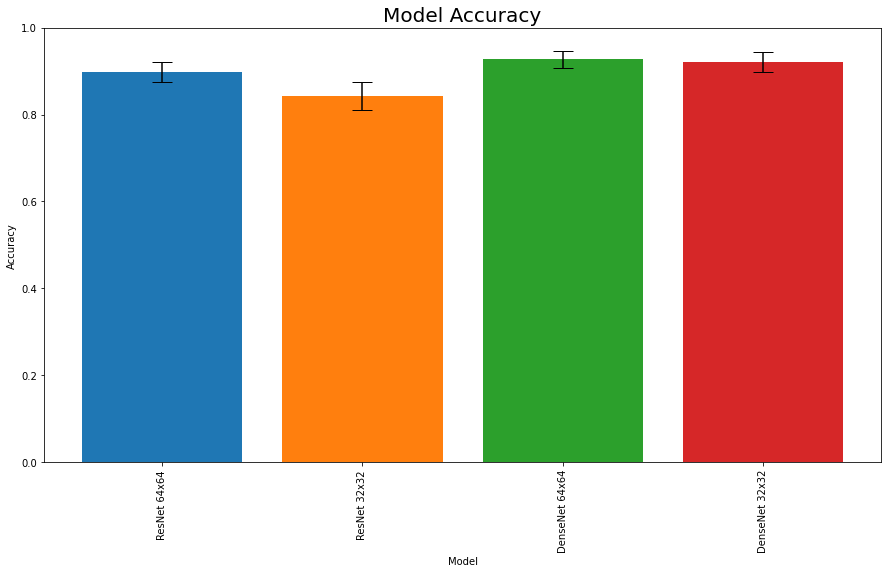

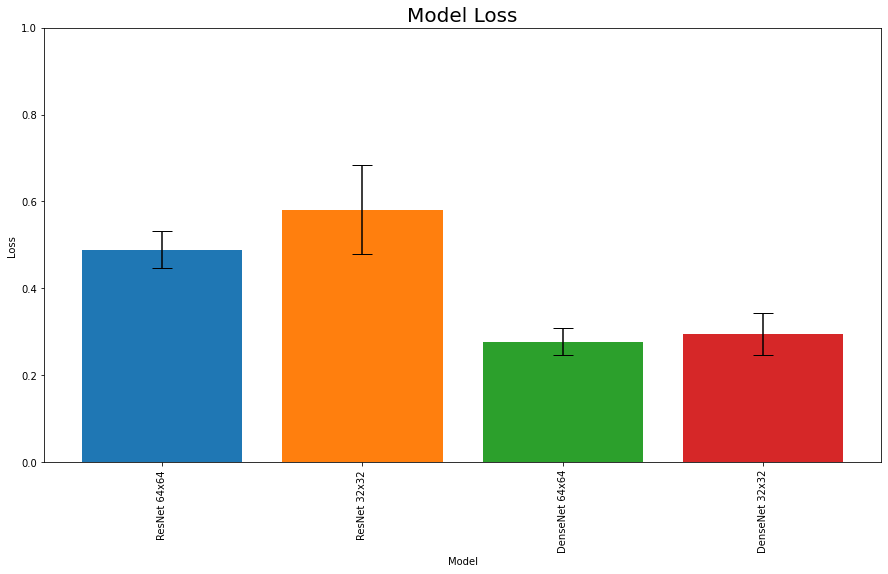

In [24]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [25]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'strat_test_culture.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64

1/1 [==============================] - 3s 3s/step - loss: 0.3326 - accuracy: 0.9147 - precision: 0.9615 - recall: 0.8523
Mean accuracy : 0.9211
Stdev accuracy : 0.0043


Mean loss : 0.2858
Stdev loss : 0.0253


F1-Score Culture: 0.9349
F1-Score No Culture: 0.9194
Macro F1-Score : 0.9272


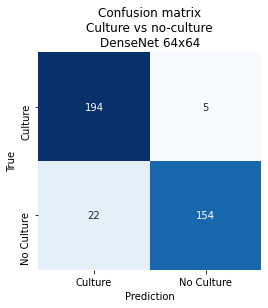

In [26]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','strat_culture_1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                    title="Confusion matrix\nCulture vs no-culture\nDenseNet 64x64", labels=["Culture", "No Culture"])

# Coffee - Spatial Cross val

In [27]:
paths = {
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_1', 'final_spacv_10FOLD_coffee_1.json'),
    'DenseNet 32x32':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_32_1', 'final_spacv_10FOLD_coffee_32_1.json'),
    'DenseNet 64x64\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee2', 'final_spacv_10FOLD_coffee2.json'),
    'DenseNet 32x32\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee_32_1', 'final_spacv_10FOLD_coffee_32_1.json'),
    'DenseNet 64x64\nAll layers unfreeze':os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_finetuning_3', 'final_spacv_10FOLD_coffee_finetuning_3.json'),
}

## Boxplot

In [28]:
epochs_accs = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        '''if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)'''
        


### Boxplot

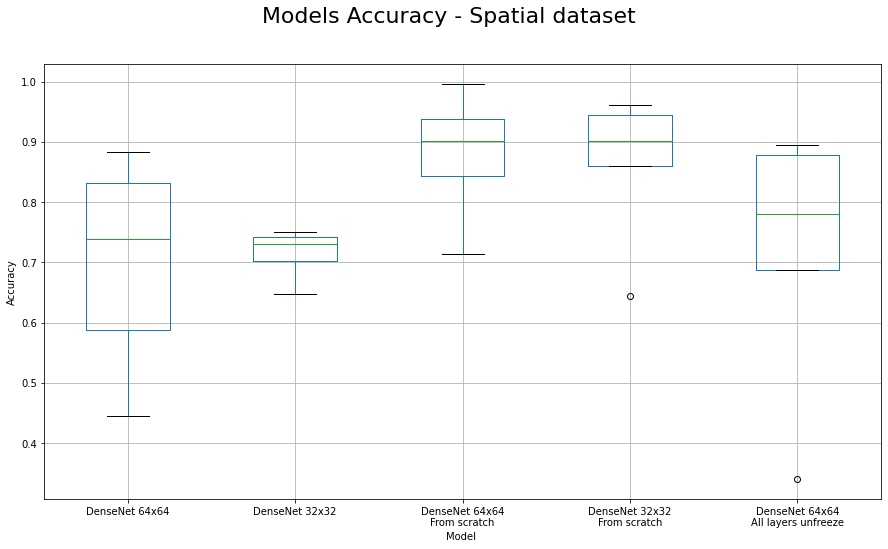

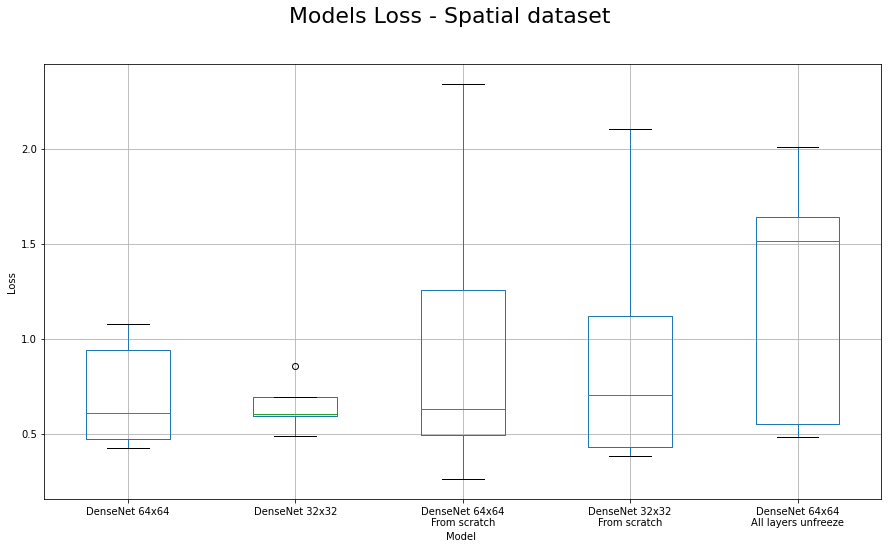

In [29]:
dict_metrics = {'Accuracy':epochs_accs, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric} - Spatial dataset", fontsize=22)
    
    ax.set_xlabel("Model ")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

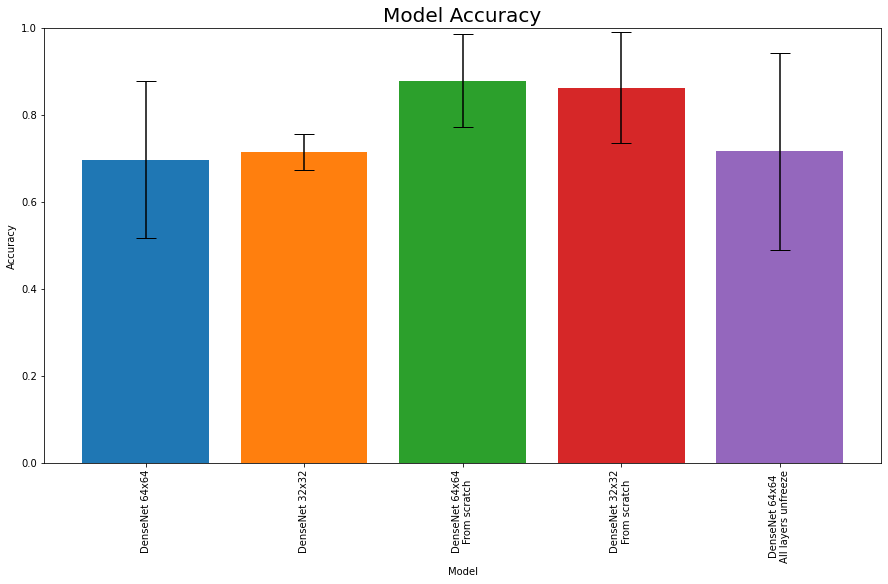

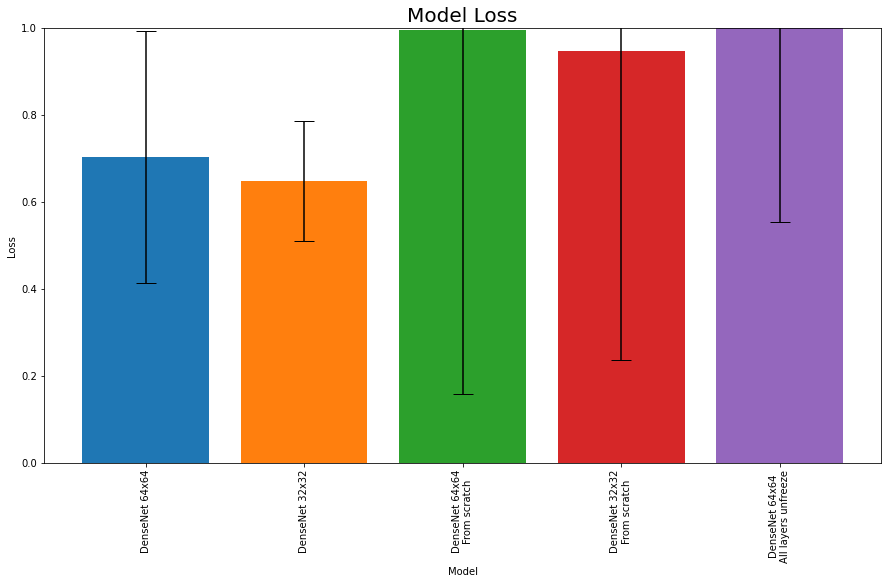

In [30]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [4]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.9620 - accuracy: 0.5885 - precision: 0.9458 - recall: 0.5016 - f1_score_keras: 0.6555
Mean accuracy : 0.5157
Stdev accuracy : 0.0887


Mean loss : 1.26
Stdev loss : 0.3895


F1-Score Coffee: 0.4559
F1-Score Other: 0.6216
Macro F1-Score : 0.5387


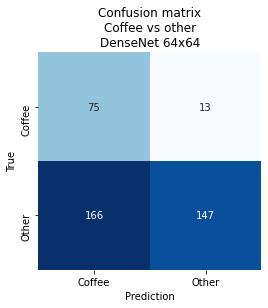

In [5]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64")

### DenseNet 64x64 From Scratch

1/1 [==============================] - 4s 4s/step - loss: 7.5936 - accuracy: 0.2369 - precision: 0.5259 - recall: 0.2268 - f1_score_keras: 0.3170
Mean accuracy : 0.3227
Stdev accuracy : 0.0639


Mean loss : 7.4515
Stdev loss : 0.97


F1-Score Coffee: 0.1424
F1-Score Other: 0.4217
Macro F1-Score : 0.2821


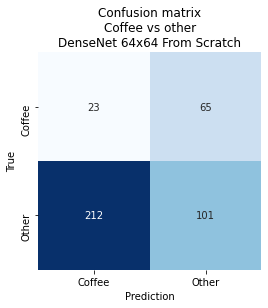

In [6]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Coffee','final_spacv_10FOLD_coffee1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64 From Scratch")

### DenseNet 64x64 Unfreeze all layers

1/1 [==============================] - 4s 4s/step - loss: 1.3329 - accuracy: 0.6708 - precision: 0.8952 - recall: 0.6550 - f1_score_keras: 0.7565
Mean accuracy : 0.609
Stdev accuracy : 0.0972


Mean loss : 2.8578
Stdev loss : 1.9973


F1-Score Coffee: 0.4549
F1-Score Other: 0.7459
Macro F1-Score : 0.6004


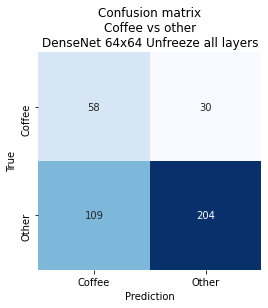

In [7]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Coffee','final_spacv_10FOLD_coffee_finetuning_3'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                    title="Confusion matrix\nCoffee vs other\nDenseNet 64x64 Unfreeze all layers")

# Culture - Spatial Cross val

In [8]:
paths = {
    'DenseNet 64x64':os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','final_spacv_10FOLD_culture_2', 'final_spacv_10FOLD_culture_ds2.json'),
    'DenseNet 64x64\nFrom scratch':os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Culture','final_spacv_10FOLD_culture_1', 'final_spacv_10FOLD_culture_ds2.json'),
    'DenseNet 64x64\nAll layers unfreeze':os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Culture','final_spacv_10FOLD_culture_finetuning_2', 'final_spacv_10FOLD_culture_finetuning_2.json')
}

## Boxplot

In [9]:
epochs_accs = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        '''if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)'''
        


### Boxplot

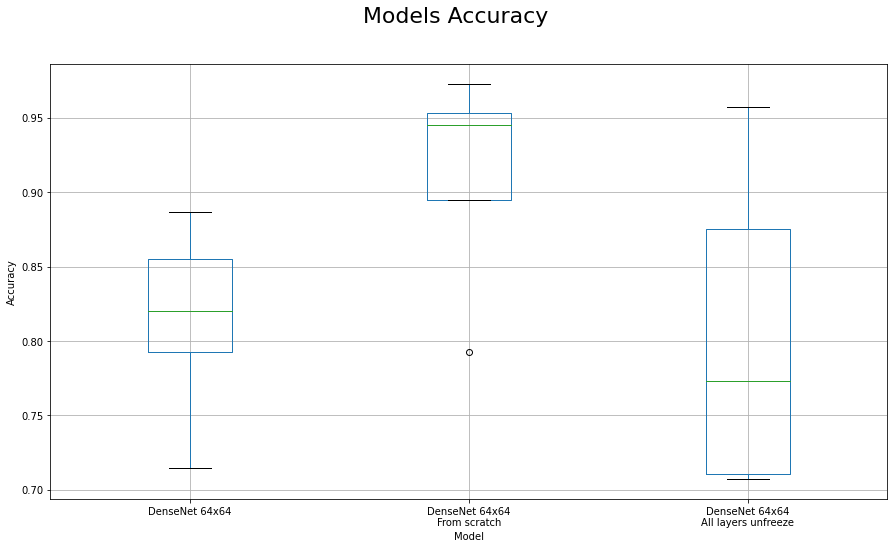

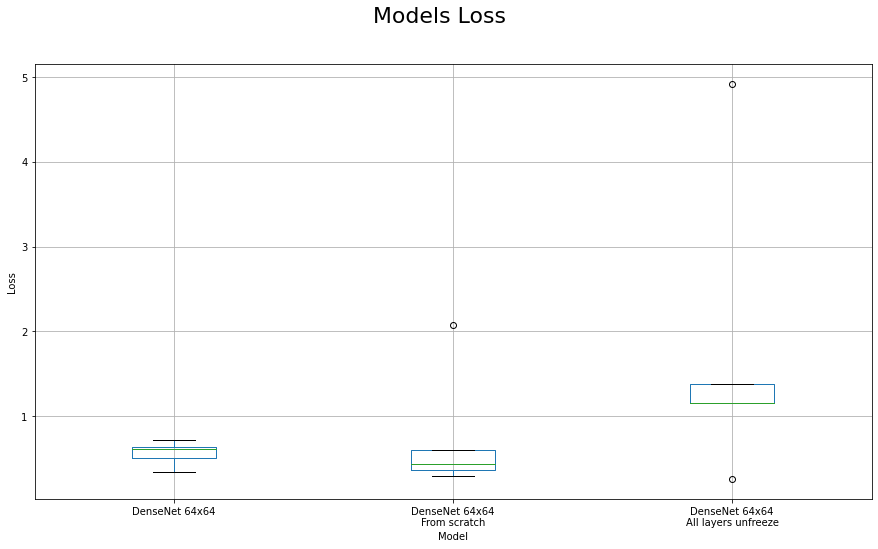

In [10]:
dict_metrics = {'Accuracy':epochs_accs,'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric}", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

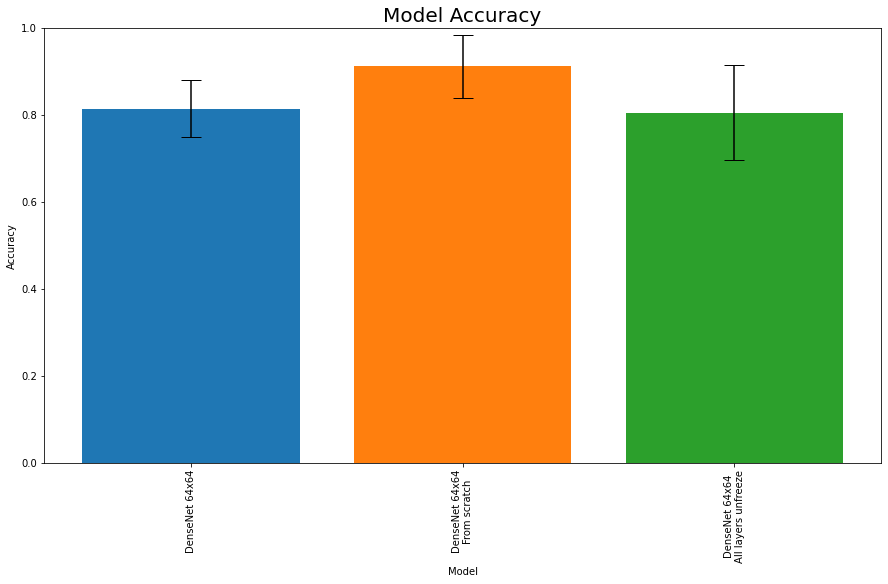

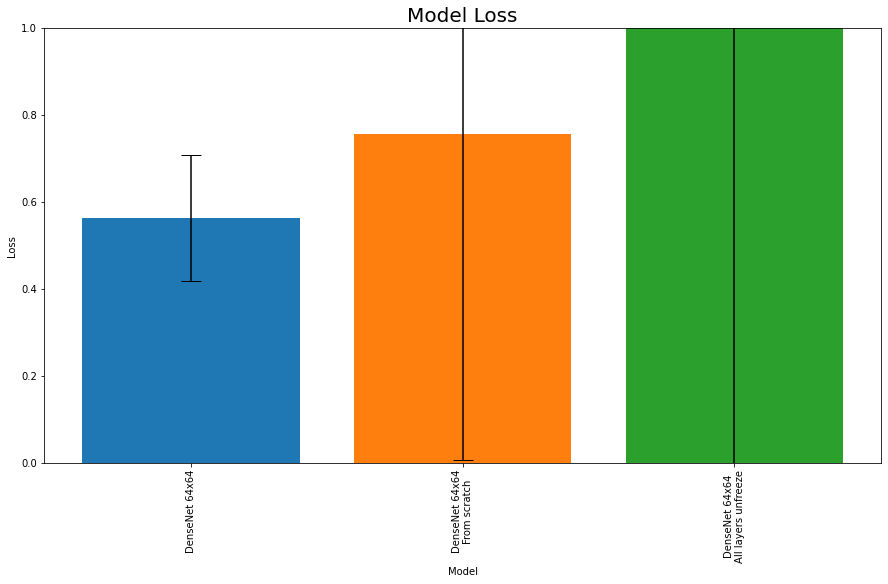

In [11]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [12]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'culture_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.3038 - accuracy: 0.9029 - precision: 0.9359 - recall: 0.8975 - f1_score_keras: 0.9163
Mean accuracy : 0.9005
Stdev accuracy : 0.0151


Mean loss : 0.3345
Stdev loss : 0.0478


F1-Score Culture: 0.9096
F1-Score No-culture: 0.9319
Macro F1-Score : 0.9208


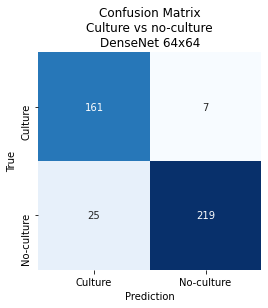

In [14]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, TRANSFER_LEARNING_PATH, 'Culture','final_spacv_10FOLD_culture_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     labels=['Culture', 'No-culture'],
                     with_f1=True,
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64")

### DenseNet 64x64 From Scratch

1/1 [==============================] - 4s 4s/step - loss: 0.6777 - accuracy: 0.8932 - precision: 0.9464 - recall: 0.8689 - f1_score_keras: 0.9060
Mean accuracy : 0.8631
Stdev accuracy : 0.0269


Mean loss : 0.9439
Stdev loss : 0.3075


F1-Score Culture: 0.8739
F1-Score No-culture: 0.9036
Macro F1-Score : 0.8888


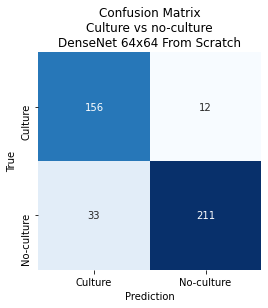

In [15]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FROM_SCRATCH_PATH, 'Culture','final_spacv_10FOLD_culture_1'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                     labels=['Culture', 'No-culture'],
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64 From Scratch")

### DenseNet 64x64 Fine tuning

1/1 [==============================] - 4s 4s/step - loss: 1.8853 - accuracy: 0.8786 - precision: 0.9254 - recall: 0.8648 - f1_score_keras: 0.8941
Mean accuracy : 0.8529
Stdev accuracy : 0.046


Mean loss : 1.192
Stdev loss : 0.4941


F1-Score Culture: 0.8772
F1-Score No-culture: 0.9129
Macro F1-Score : 0.895


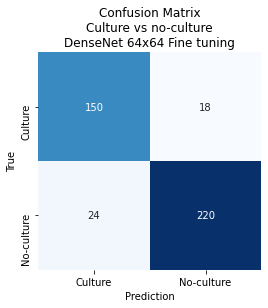

In [16]:
set_model_prediction(os.path.join(SAVED_MODELS_PATH, FINE_TUNING_PATH, 'Culture','final_spacv_10FOLD_culture_finetuning_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True,
                     labels=['Culture', 'No-culture'],
                     title="Confusion Matrix\nCulture vs no-culture\nDenseNet 64x64 Fine tuning")

# Spatial cross val Multilabel (coffee / culture)

In [19]:
paths = {
    'DenseNet 64x64 coffee-culture':os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_3', 'final_spacv_10FOLD_multilabel_3.json'),
}

In [20]:
epochs_accs = []
epochs_loss = []

for name, path in paths.items():
    with open(path) as json_file:
        data = json.load(json_file)
        
        metrics = list(zip(*data))
        
        epochs_loss.append(metrics[0])
        epochs_accs.append(metrics[1])

        '''if len(metrics) > 4:
            epochs_f1.append(metrics[4])
        else:
            tmp = []
            for i in range(0,len(metrics[2])):
                tmp.append(2*((metrics[2][i]*metrics[3][i]) / (metrics[2][i]+metrics[3][i])))
            epochs_f1.append(tmp)'''
        


### Boxplot

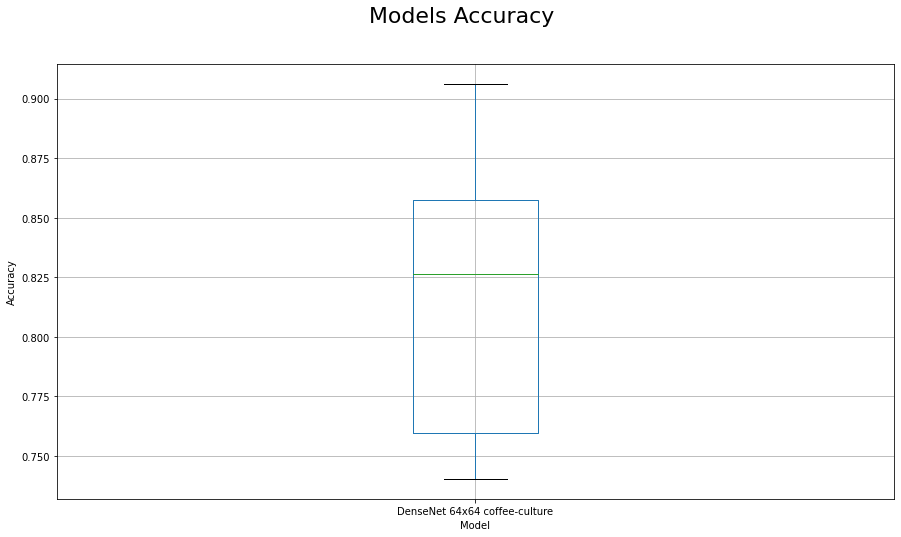

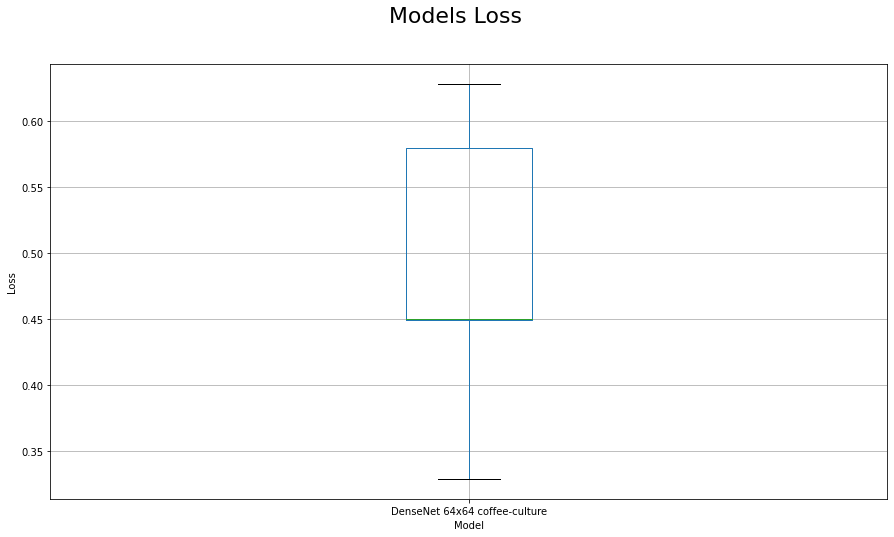

In [21]:
dict_metrics = {'Accuracy':epochs_accs, 'Loss':epochs_loss}

for metric, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())

    fig, ax = plt.subplots(figsize=(15,8))
    fig.suptitle(f"Models {metric}", fontsize=22)
    
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)

    
    df_metric.boxplot(ax=ax)

## Histogramme

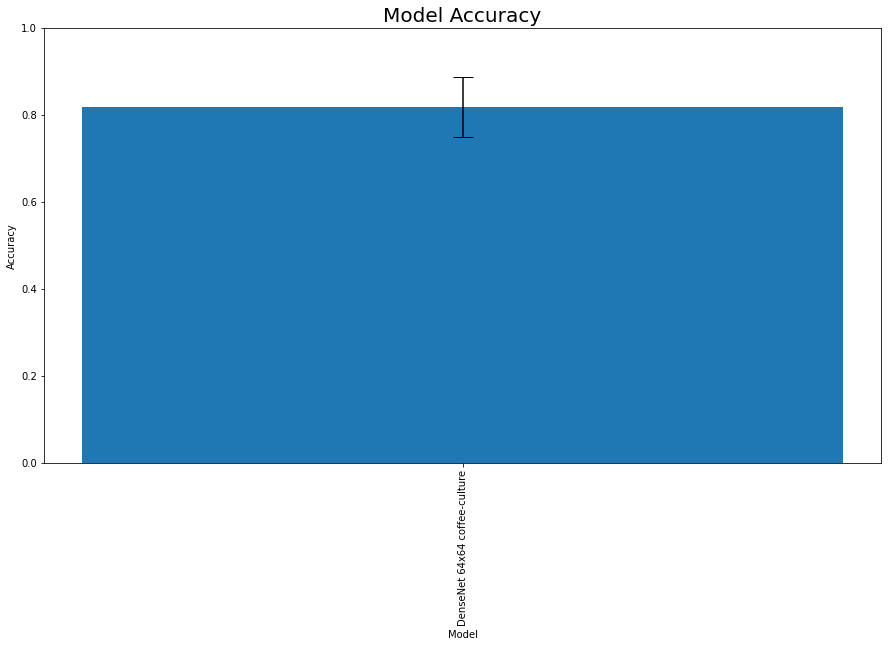

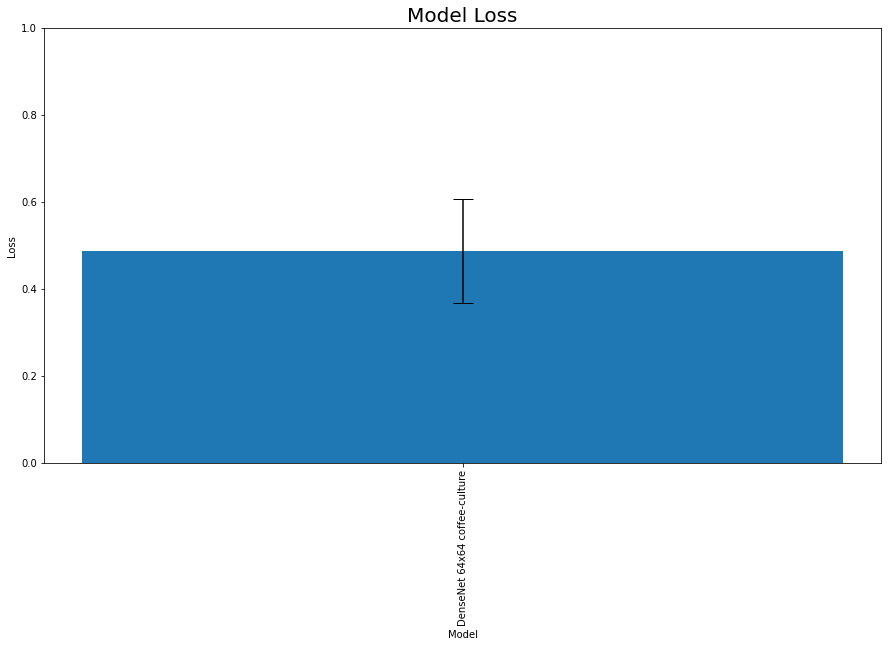

In [22]:
for name, values in dict_metrics.items():
    df_metric = pd.DataFrame(values).T
    df_metric.columns = list(paths.keys())
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    means = df_metric.mean(axis=0).to_numpy()
    stds = df_metric.std(axis=0).to_numpy()

    ax.bar(list(paths.keys()), means, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'], yerr=stds, align='center', capsize=10)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xlabel("Model")
    ax.set_ylabel(name)
    ax.set_title(f"Model {name}", fontsize=20)
    ax.set_ylim([0,1])

## Prediction on test set

In [7]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'culture_coffee_10fold','test_data.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

### DenseNet 64x64 

1/1 [==============================] - 4s 4s/step - loss: 0.6946 - accuracy: 0.7570 - precision: 0.8190 - recall: 0.7611 - f1_score_keras: 0.7890
Global metrics
Mean accuracy : 0.6894
Stdev accuracy : 0.0365


Mean loss : 0.8379
Stdev loss : 0.0867


Culture vs no-culture
F1-Score Culture: 0.6708
F1-Score No culture: 0.5597
Macro F1-Score : 0.6152


Coffee vs other
F1-Score Coffee: 0.2991
F1-Score Other: 0.8373
Macro F1-Score : 0.5682


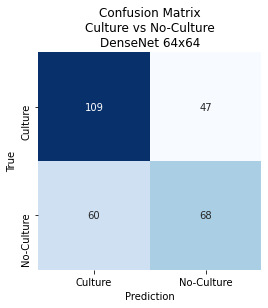

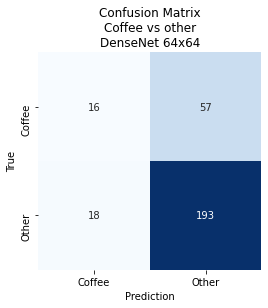

In [5]:
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_3'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

1/1 [==============================] - 3s 3s/step - loss: 0.3026 - accuracy: 0.8838 - precision: 0.7984 - recall: 0.9194 - f1_score_keras: 0.8546
Global metrics
Mean accuracy : 0.887
Stdev accuracy : 0.0149


Mean loss : 0.3535
Stdev loss : 0.0676


Culture vs no-culture
F1-Score Culture: 1.0
F1-Score No culture: 0.0
Macro F1-Score : 1.0


Coffee vs other
F1-Score Coffee: 0.4118
F1-Score Other: 0.8712
Macro F1-Score : 0.6415


/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


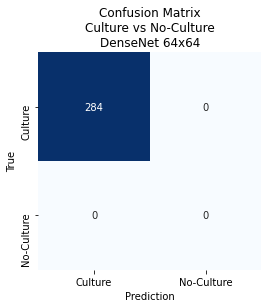

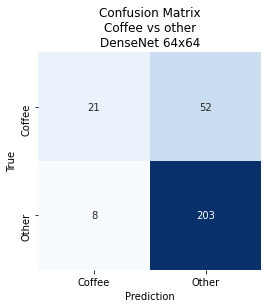

In [6]:
data_test['label_culture'] = 0
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_culture_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

1/1 [==============================] - 4s 4s/step - loss: 0.4964 - accuracy: 0.8873 - precision: 0.9571 - recall: 0.5234 - f1_score_keras: 0.6768
Global metrics
Mean accuracy : 0.8468
Stdev accuracy : 0.0263


Mean loss : 0.5651
Stdev loss : 0.0589


Culture vs no-culture
F1-Score Culture: 0.7536
F1-Score No culture: 0.6188
Macro F1-Score : 0.6862


Coffee vs other
F1-Score Coffee: 1.0
F1-Score Other: 0.0
Macro F1-Score : 1.0


/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


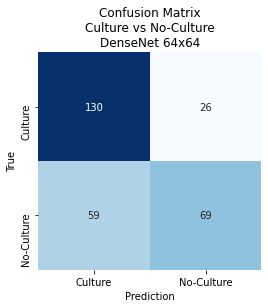

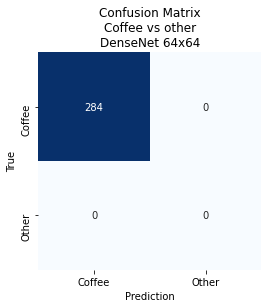

In [8]:
data_test['label_coffee'] = 0
set_model_prediction_multi_label(os.path.join(SAVED_MODELS_PATH, MULTI_LABEL_PATH, 'multi_label','final_spacv_10FOLD_multilabel_coffee_2'), 
                     data_test, 
                     custom_objects={'LeakyReLU':LeakyReLU},
                     with_f1=True)

# Band variation model - DenseNet201
## 3 bands 

In [50]:
history_13bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_13bands_1', 'band_variation3_13bands_1.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_RGB_SWIR_1', 'band_variation3_RGB_SWIR_1.npy'),allow_pickle='TRUE').item()
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'band_variation','Coffee','band_variation3_highres_1', 'band_variation3_highres_1.npy'),allow_pickle='TRUE').item()
history_transfer_learning = np.load(os.path.join('saved_models','transfer_learning', 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

13 bands test accuracy : 0.4865364134311676
High res test accuracy : 0.47848957777023315
RGB + SWIR test accuracy : 0.6016015410423279
Original model test accuracy : 0.71833336353302


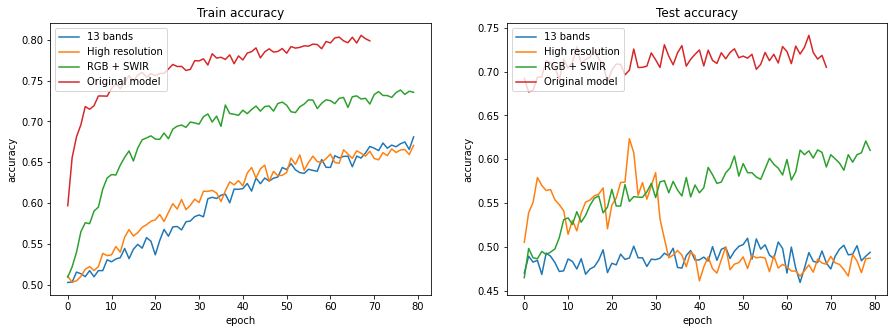

In [52]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['accuracy'])
axes[0].plot(history_highres_bands['accuracy'])
axes[0].plot(history_rgb_swir_bands['accuracy'])
axes[0].plot(history_transfer_learning['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR','Original model'], loc='upper left')

axes[1].plot(history_13bands['val_accuracy'])
axes[1].plot(history_highres_bands['val_accuracy'])
axes[1].plot(history_rgb_swir_bands['val_accuracy'])
axes[1].plot(history_transfer_learning['val_accuracy'])
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

print(f"13 bands test accuracy : {np.mean(history_13bands['val_accuracy'][-20:])}")
print(f"High res test accuracy : {np.mean(history_highres_bands['val_accuracy'][-20:])}")
print(f"RGB + SWIR test accuracy : {np.mean(history_rgb_swir_bands['val_accuracy'][-20:])}")
print(f"Original model test accuracy : {np.mean(history_transfer_learning['val_accuracy'][-20:])}")

13 bands test loss : 1.0146326931317649
High res test loss : 0.8543806447585425
RGB + SWIR test loss : 0.7041762778162955
Original model test loss : 0.702540054048101


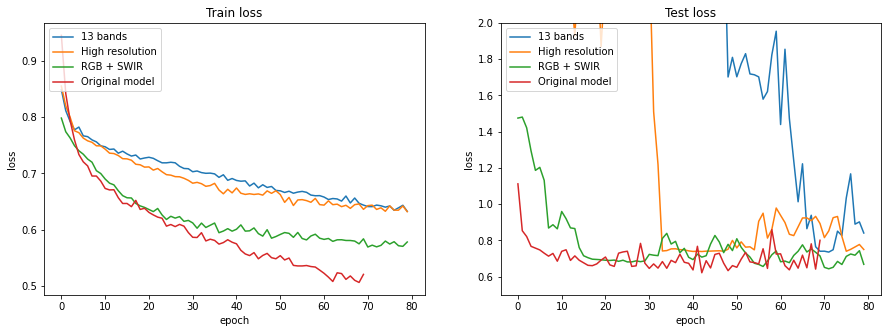

In [53]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['loss'])
axes[0].plot(history_highres_bands['loss'])
axes[0].plot(history_rgb_swir_bands['loss'])
axes[0].plot(history_transfer_learning['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

axes[1].plot(history_13bands['val_loss'])
axes[1].plot(history_highres_bands['val_loss'])
axes[1].plot(history_rgb_swir_bands['val_loss'])
axes[1].plot(history_transfer_learning['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0.5,2])
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR', 'Original model'], loc='upper left')

print(f"13 bands test loss : {np.mean(history_13bands['val_loss'][-20:])}")
print(f"High res test loss : {np.mean(history_highres_bands['val_loss'][-20:])}")
print(f"RGB + SWIR test loss : {np.mean(history_rgb_swir_bands['val_loss'][-20:])}")
print(f"Original model test loss : {np.mean(history_transfer_learning['val_loss'][-20:])}")

## 13 bands model

In [54]:
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH,'band_variation', 'Coffee','band_variation13_highres', 'band_variation13_highres.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH,'band_variation',  'Coffee','band_variation13_RGB_SWR', 'band_variation13_RGB_SWR.npy'),allow_pickle='TRUE').item()
history_transfer_learning = np.load(os.path.join('saved_models','transfer_learning', 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

High res test accuracy : 0.5473177433013916
RGB + SWIR test accuracy : 0.6244140863418579
Original model test accuracy : 0.71833336353302


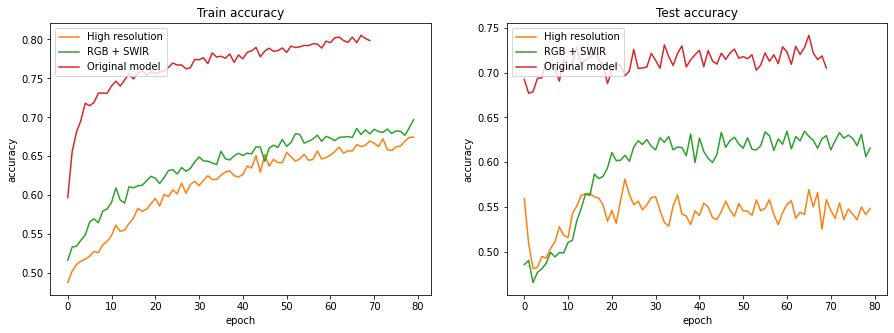

In [56]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_highres_bands['accuracy'], color='tab:orange')
axes[0].plot(history_rgb_swir_bands['accuracy'], color='tab:green')
axes[0].plot(history_transfer_learning['accuracy'], color='tab:red')
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['High resolution','RGB + SWIR', 'Original model'], loc='upper left')

axes[1].plot(history_highres_bands['val_accuracy'], color='tab:orange')
axes[1].plot(history_rgb_swir_bands['val_accuracy'], color='tab:green')
axes[1].plot(history_transfer_learning['val_accuracy'], color='tab:red')
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['High resolution','RGB + SWIR', 'Original model'], loc='upper left')

print(f"High res test accuracy : {np.mean(history_highres_bands['val_accuracy'][-20:])}")
print(f"RGB + SWIR test accuracy : {np.mean(history_rgb_swir_bands['val_accuracy'][-20:])}")
print(f"Original model test accuracy : {np.mean(history_transfer_learning['val_accuracy'][-20:])}")

High res test loss : 0.7385803946355978
RGB + SWIR test loss : 0.7478472946584225
Original model test loss : 0.702540054048101


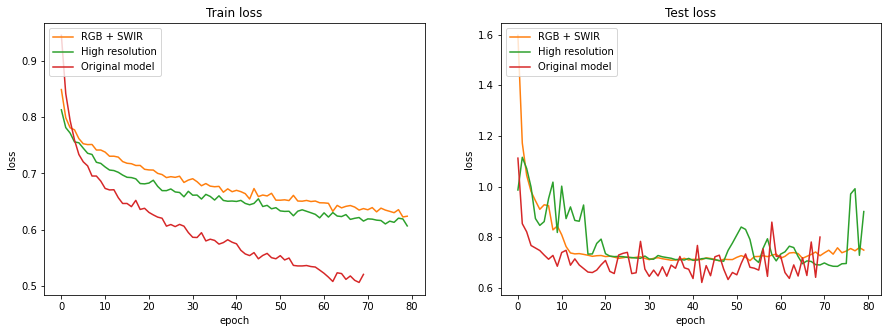

In [57]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_highres_bands['loss'], color='tab:orange')
axes[0].plot(history_rgb_swir_bands['loss'], color='tab:green')
axes[0].plot(history_transfer_learning['loss'], color='tab:red')
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['RGB + SWIR', 'High resolution', 'Original model'], loc='upper left')

axes[1].plot(history_highres_bands['val_loss'], color='tab:orange')
axes[1].plot(history_rgb_swir_bands['val_loss'], color='tab:green')
axes[1].plot(history_transfer_learning['val_loss'], color='tab:red')
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['RGB + SWIR', 'High resolution', 'Original model'], loc='upper left')

print(f"High res test loss : {np.mean(history_highres_bands['val_loss'][-20:])}")
print(f"RGB + SWIR test loss : {np.mean(history_rgb_swir_bands['val_loss'][-20:])}")
print(f"Original model test loss : {np.mean(history_transfer_learning['val_loss'][-20:])}")